In [1]:
import os
os.chdir("..")
import numpy as np
from CPSL_Radar.Analyzer import Analyzer
from CPSL_Radar.datasets.Dataset_Generator import DatasetGenerator
from torchvision import transforms

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#initialize the dataset generator
#location of the CPSL dataset we wish to process
dataset_folder = "/data/david/CPSL_Ground/recorded_datasets/"
scenario_folders = sorted(os.listdir(dataset_folder))

train_scenarios = [os.path.join(dataset_folder,scenario_folder) for
                   scenario_folder in scenario_folders[0:-1]]
test_scenarios = [os.path.join(dataset_folder,scenario_folders[-1])]

scenarios_to_use = test_scenarios

#location that we wish to save the dataset to
generated_dataset_path = "/data/david/CPSL_Ground/test/"

#specifying the names for the files
generated_file_name = "frame"
radar_data_folder = "radar"
lidar_data_folder = "lidar"

#basic dataset settings
num_chirps_to_save = 1
num_previous_frames = 40

#initialize the DatasetGenerator
dataset_generator = DatasetGenerator()

dataset_generator.config_generated_dataset_paths(
    generated_dataset_path=generated_dataset_path,
    generated_file_name=generated_file_name,
    generated_radar_data_folder=radar_data_folder,
    generated_lidar_data_folder=lidar_data_folder,
    clear_existing_data=False
)

#configure the radar data processor
dataset_generator.config_radar_data_processor(
    max_range_bin=64,
    num_chirps_to_save=num_chirps_to_save,
    num_previous_frames=num_previous_frames,
    radar_fov= [-0.87, 0.87], #+/- 50 degrees
    num_angle_bins=64,
    power_range_dB=[60,105],
    chirps_per_frame= 64,
    rx_channels = 4,
    tx_channels = 1,
    samples_per_chirp = 64,
    adc_sample_rate_Hz = 2e6,
    chirp_slope_MHz_us= 35,
    start_freq_Hz=77e9,
    idle_time_us = 100,
    ramp_end_time_us = 100
)

#configure the lidar data processor
dataset_generator.config_lidar_data_processor(
    max_range_m=8.56,
    num_range_bins=64,
    angle_range_rad=[-np.pi/2 - 0.87,-np.pi/2 + 0.87], #[-np.pi /2 , np.pi /2],
    num_angle_bins=48,
    num_previous_frames=num_previous_frames
)

DatasetGenerator._check_for_directory: found directory /data/david/CPSL_Ground/test/
DatasetGenerator._check_for_directory: found directory /data/david/CPSL_Ground/test/radar
DatasetGenerator._check_for_directory: found directory /data/david/CPSL_Ground/test/lidar
max range: 8.5654988m
num actual angle bins: 48


In [3]:
#generate the test dataset if needed
# dataset_generator.generate_dataset()

In [4]:
#initialize the transforms
unet_transforms = [
    transforms.ToTensor(),
    transforms.Resize((64,48))
]

#initialize the viewer
result_analyzer = Analyzer(
    dataset_generator=dataset_generator,
    transforms_to_apply= unet_transforms,
    working_dir="working_dir/CPSL_Ground_frame_based",
    model_file_name="trained_bce_b1024_e40.pth",
    cuda_device="cuda:0"
)

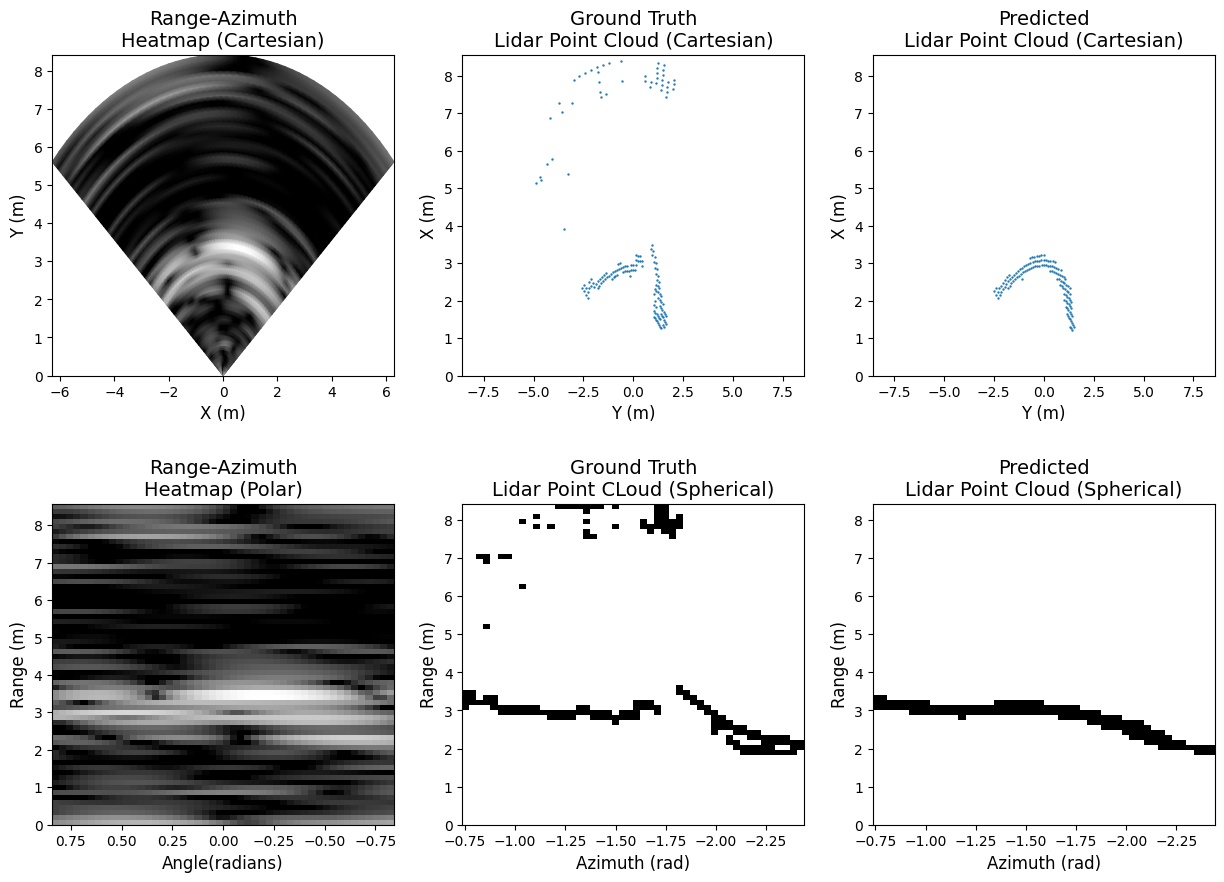

In [5]:
#show the results for a given sample
result_analyzer.view_result(sample_idx=222)

Analyzer.compute_all_chamfer_hausdorff_distances: Computing chamfer and hausdorff distances


100%|██████████| 5282/5282 [00:20<00:00, 253.15it/s]


Analyzer.compute_all_chamfer_hausdorff_distances: number failed predictoins 0 of 5282 (0.0%)


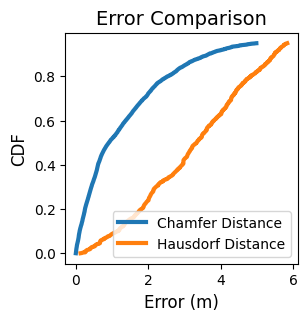

In [6]:
result_analyzer.plot_chamfer_hausdorf_cdfs()